In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, utils, models
from pathlib import Path
from skimage import io, util, morphology
import time
from datetime import datetime
import copy
import cv2

plt.ion()

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Configuration and Experiment Parameters

In [3]:
PATH = Path('/wdblue/deep_image_matting/Combined_Dataset/Training_set')
TEST = Path('/wdblue/deep_image_matting/Combined_Dataset/Test_set/Adobe-licensed images')
TRIMAPS = PATH/'trimap'
TEST_TRI = TEST/'trimaps'
TEST_MASK = Path('/wdblue/deep_image_matting/Combined_Dataset/Test_set/Adobe-licensed images/alpha')
TRAIN = PATH/'merged'
FG = PATH/'fg'
BG = PATH/'bg'
MASKS = PATH/'mask'

## Trimap Generation and Testing *Consider alpha channel instead of only the first channel

In [4]:
def mapto255(x):
    if(x > 0):
        return 255
    else:
        return 0
    
vmap = np.vectorize(mapto255)

In [5]:
def mapto255_2(x):
    if(x > 191):
        return 255
    else:
        return 0
    
vmap2 = np.vectorize(mapto255_2)

In [6]:
# # Create and save trimaps from ground-truth masks
# kernel = np.ones((35,35), np.uint8)
# for fn in os.listdir(MASKS):
#     im = io.imread(MASKS/fn)
#     if(len(im.shape) == 3):
#         im = im[:,:,0]
#     trimap = ((0.5 * morphology.dilation(vmap(im), kernel))+(0.5 * morphology.erosion(vmap2(im), kernel))).astype(np.uint8)
#     io.imsave(TRIMAPS/(fn[:-3] + 'png'), trimap)

# Build Dataloader with Transforms

In [7]:
# Helper function to deal with filename structure
# Each image of a foreground with a ground-truth matte is composited on hundreds of backgrounds
def find_last_idx(s):
    idx = -1
    while(True):
        try:
            new_idx = s[idx+1:].index('_')
            idx = idx + new_idx + 1
        except:
            return idx

In [8]:
class MatteDataset1(Dataset):    
    def __init__(self, filenames, root_dir, transform=None):
        self.fns = filenames
        self.root_dir = root_dir
        self.transform = transform
        self.kernel = np.ones((32,32), np.uint8)

        
    def __len__(self):
        return len(self.fns)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,
                                'merged',
                                self.fns[idx])
        midx = find_last_idx(self.fns[idx])
        mask_path = os.path.join(self.root_dir,
                                 'mask',
                                 self.fns[idx][:midx]+'.jpg')
        trimap_path = os.path.join(self.root_dir,
                                 'trimap',
                                 self.fns[idx][:midx]+'.png')
        
        image = io.imread(img_path).astype(np.uint8)
        trimap = np.expand_dims(io.imread(trimap_path), -1).astype(np.uint8)
        mask = io.imread(mask_path).astype(np.uint8)
        if(len(mask.shape) == 2):
            mask = np.expand_dims(mask, -1)
            
        h, w = image.shape[0], image.shape[1]
        if(h < 330 or w < 330):
#             print("PADDING", self.fns[idx])
            pad = [330-h, 330-w]
            if(pad[0] < 0):
                pad[0] = 0
            if(pad[1] < 0):
                pad[1] = 0
            h, w = h + pad[0], w + pad[1]
            pad = [(0, pad[0]), (0, pad[1]), (0, 0)]
            image = util.pad(image, pad, mode='reflect')
            trimap = util.pad(trimap, pad, mode='reflect')
            mask = util.pad(mask, pad, mode='reflect')

        im_map = np.concatenate((image, trimap), axis=2)
        im_map = np.multiply(im_map, (1/255))
        mask = np.multiply(mask, (1/255))
            
#         sample = {'im_map': im_map, 'mask': mask, 'image': image, 'fn': self.fns[idx], 'trimap': trimap}
        sample = {'im_map': im_map, 'mask': mask, 'fn': self.fns[idx]}

        if self.transform:
            sample = self.transform(sample)
    
        return sample

In [9]:
class MatteDataset(Dataset):    
    def __init__(self, filenames, root_dir, fg_path, transform=None):
        self.fns = filenames
        self.root_dir = root_dir
        self.transform = transform
        self.kernel = np.ones((32,32), np.uint8)
        self.fg_path = fg_path
        self.fgs = os.listdir(self.fg_path)
        self.vmap1 = np.vectorize(self.mapto255)
        self.vmap2 = np.vectorize(self.mapto255_2)
        
    def __len__(self):
        return len(self.fns)
        
    def mapto255(self, x):
        if(x > 0):
            return 255
        else:
            return 0
        
    def mapto255_2(self, x):
        if(x > 191):
            return 255
        else:
            return 0
    
    def __getitem__(self, idx):
        fn = self.fgs[np.random.randint(0, len(self.fgs))]
        fg = io.imread(self.fg_path/fn)
        mask = io.imread(self.root_dir/'mask'/fn)
        bg = io.imread(self.root_dir/'bg'/self.fns[idx])
                    
        bg = bg.astype(np.float64)
        fg = cv2.resize(fg, (bg.shape[1], bg.shape[0])).astype(np.float64)
        mask = cv2.resize(mask, (bg.shape[1], bg.shape[0])).astype(np.uint8)
        
        alpha = np.array([mask/255]*3).transpose(1,2,0).astype(np.float64)
        foreground = np.multiply(alpha, fg)
#         print((1.0 - alpha).shape, bg.shape)
        background = np.multiply(1.0 - alpha, bg)
        image = cv2.add(foreground, background).astype(np.uint8)
                
        kernel = np.ones((np.random.randint(20, 40), np.random.randint(20, 40)), np.uint8)
        trimap = ((0.5 * morphology.dilation(self.vmap1(mask), kernel))+\
                  (0.5 * morphology.erosion(self.vmap2(mask), kernel))).astype(np.uint8)
        trimap = np.expand_dims(trimap, -1)

        if(len(mask.shape) == 2):
            mask = np.expand_dims(mask, -1)
            
        h, w = image.shape[0], image.shape[1]
        if(h < 330 or w < 330):
#             print("PADDING", self.fns[idx])
            pad = [330-h, 330-w]
            if(pad[0] < 0):
                pad[0] = 0
            if(pad[1] < 0):
                pad[1] = 0
            h, w = h + pad[0], w + pad[1]
            pad = [(0, pad[0]), (0, pad[1]), (0, 0)]
            image = util.pad(image, pad, mode='reflect')
            trimap = util.pad(trimap, pad, mode='reflect')
            mask = util.pad(mask, pad, mode='reflect')
            fg = util.pad(fg, pad, mode='reflect')
            bg = util.pad(bg, pad, mode='reflect')

        im_map = np.concatenate((image, trimap), axis=2)
        im_map = np.multiply(im_map, (1/255))
        mask = np.multiply(mask, (1/255))
            
        sample = {'im_map': im_map, 'mask': mask, 'bg': bg, 'fg': fg}

        if self.transform:
            sample = self.transform(sample)
    
        return sample

In [10]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        im_map, mask, bg, fg = sample['im_map'], sample['mask'], sample['bg'], sample['fg']

        h, w = im_map.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        im_map = im_map[top: top + new_h,
                        left: left + new_w]
        
        mask = mask[top: top + new_h,
                    left: left + new_w]

        bg = bg[top: top + new_h,
                    left: left + new_w]
        
        fg = fg[top: top + new_h,
                    left: left + new_w]

        return {'im_map': im_map, 'mask': mask, 'bg': bg, 'fg': fg}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        im_map, mask, bg, fg = sample['im_map'], sample['mask'], sample['bg'], sample['fg']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        im_map = im_map.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        bg = bg.transpose((2, 0, 1))
        fg = fg.transpose((2, 0, 1))
        return {'im_map': torch.from_numpy(im_map).float(),
                'mask': torch.from_numpy(mask).float(),
                'bg': torch.from_numpy(bg).float(),
                'fg': torch.from_numpy(fg).float()}

In [11]:
class RandomCrop1(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        im_map, mask, fn = sample['im_map'], sample['mask'], sample['fn']

        h, w = im_map.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        im_map = im_map[top: top + new_h,
                        left: left + new_w]
        
        mask = mask[top: top + new_h,
                    left: left + new_w]

        return {'im_map': im_map, 'mask': mask, 'fn': fn}


class ToTensor1(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        im_map, mask, fn = sample['im_map'], sample['mask'], sample['fn']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        im_map = im_map.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'im_map': torch.from_numpy(im_map).float(),
                'mask': torch.from_numpy(mask).float(),
                'fn': fn}

In [12]:
# Augmentation with transformations

data_transform = transforms.Compose([
    RandomCrop(320),
    ToTensor()
])

In [13]:
# ds = MatteDataset(os.listdir(BG), PATH, FG, data_transform)
# dl = DataLoader(ds, shuffle=True)

In [14]:
# image, trimap, mask, bg, fg = 0, 0, 0, 0, 0
# a, b, f = 0, 0, 0
# for i, sample in enumerate(dl):
#     if(i==1):
#         break
#     imt, m, background, foreground = sample['im_map'], sample['mask'], sample['bg'], sample['fg']
#     image = (imt[0][:3, :, :].numpy()*255).astype(np.uint8).transpose((1,2,0))
#     trimap = (imt[0][3, :, :].numpy()*255).astype(np.uint8)
#     mask = (m[0].numpy()*255).astype(np.uint8)[0]
#     bg = (background[0].numpy()).astype(np.uint8).transpose((1,2,0))
#     fg = (foreground[0].numpy()).astype(np.uint8).transpose((1,2,0))
#     a = m
#     b = background
#     f = foreground
#     print(imt.shape, m.shape, bg.shape, fg.shape, mask.shape, trimap.shape, image.shape, a.shape, b.shape, f.shape)

In [15]:
# io.imshow(composite(f,b,a).numpy().astype(np.uint8)[0].transpose((1,2,0)))

In [16]:
# io.imshow(image)

In [17]:
# io.imshow(trimap)

In [18]:
# io.imshow(mask)

In [19]:
# io.imshow(bg)

In [20]:
# io.imshow(fg)

In [21]:
# for i,fn in enumerate(os.listdir(BG)):
#     if(i % 10000 == 0):
#         print(i)
#     im = io.imread(BG/fn)
#     if(len(im.shape)!=3):
#         print(fn)
#         os.remove(BG/fn)

# Model Definition

In [22]:
class DecoderBlock(nn.Module):
    # USES ADDITION INSTEAD OF CONCATENATION ON SKIP CONNECTIONS
    
    
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nn.ReLU(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class LinkNet34(nn.Module):
    def __init__(self, num_classes, num_channels=4):
        super().__init__()
        assert num_channels == 4, "num channels not used now. to use changle first conv layer to support num channels other then 3"
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)
        
        # get the pre-trained weights of the first layer
        pretrained_weights = resnet.conv1.weight
        new_features = nn.Sequential(*list(resnet.children()))
        new_features.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # For M-channel weight should randomly initialized with Gaussian
        new_features.conv1.weight.data.normal_(0, 0.001)
        # For RGB it should be copied from pretrained weights
        new_features.conv1.weight.data[:, :3, :, :] = pretrained_weights
        resnet.conv1 = new_features.conv1


##         resnet.conv1.weight = nn.Parameter(torch.cat((resnet.conv1.weight, torch.tensor(np.zeros((64,1,7,7)), dtype=torch.float32, requires_grad=True)), 1))

#         trained_kernel = resnet.conv1.weight
#         new_conv = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         new_conv.weight[:,:3] = trained_kernel
#         new_conv.weight[:,3:] = torch.tensor(np.zeros((64,1,7,7)), dtype=torch.float32, requires_grad=True, device='cuda')

        
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        # d4 = e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        return f5

# Specify Loss Function(s)

In [23]:
def composite(fg, bg, alpha):
    foreground = torch.mul(alpha, fg)
    background = torch.mul(1.0 - alpha, bg)
    return torch.add(foreground, background)

class _Loss(nn.Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

def alpha_pred_loss(p_mask, gt_mask, eps=1e-6):
    return torch.sqrt(gt_mask.sub(p_mask).pow(2).sum() + eps)

def alpha_pred_loss_weighted(p_mask, gt_mask, trimap, eps=1e-6):
    return torch.sqrt(torch.mul(gt_mask.sub(p_mask).pow(2), torch.eq(trimap, torch.FloatTensor(np.ones(gt_mask.shape)*(127./255)).to(device)).float()).sum() + eps)


class temp_loss(_Loss):
    def __init__(self, eps=1e-6):
        super(temp_loss, self).__init__()
        self.eps = eps
        
#     def forward(self, p_mask, gt_mask, trimap):
#         return alpha_pred_loss(p_mask, gt_mask, trimap, self.eps)
    def forward(self, p_mask, gt_mask):
        return alpha_pred_loss(p_mask, gt_mask, self.eps)

def compositional_loss(p_mask, gt_mask, fg, bg, eps=1e-6):
    gt_comp = composite(fg, bg, gt_mask)
    p_comp = composite(fg, bg, p_mask)
    return torch.sqrt(gt_comp.sub(p_comp).pow(2).sum() + eps)

def compositional_loss_weighted(p_mask, gt_mask, fg, bg, trimap, eps=1e-6):
    gt_comp = composite(fg, bg, gt_mask)
    p_comp = composite(fg, bg, p_mask)
    bs, h, w = trimap.shape
    unknown = torch.eq(trimap, torch.FloatTensor(np.ones(trimap.shape)*(127./255)).to(device)).float().expand(3, bs, h, w).contiguous().view(bs,3,h,w)
    s_diff = gt_comp.sub(p_comp).pow(2)
    return torch.sqrt(torch.mul(s_diff, unknown).sum() + eps)
    
class dim_loss(_Loss):
    def __init__(self, eps=1e-6, w=0.5):
        super(dim_loss, self).__init__()
        self.eps = eps
        self.w = w
        
    def forward(self, p_mask, gt_mask, fg, bg):
        return self.w * alpha_pred_loss(p_mask, gt_mask, self.eps) + (1-self.w) * compositional_loss(p_mask, gt_mask, fg, bg, self.eps)
    
class dim_loss_weighted(_Loss):
    def __init__(self, eps=1e-6, w=0.5):
        super(dim_loss_weighted, self).__init__()
        self.eps = eps
        self.w = w
        
    def forward(self, p_mask, gt_mask, fg, bg, trimap):
        return self.w * alpha_pred_loss_weighted(p_mask, gt_mask, trimap, self.eps) + (1-self.w) * compositional_loss_weighted(p_mask, gt_mask, fg, bg, trimap, self.eps)

# Training Loop

In [24]:
fns = np.array(os.listdir(BG))
val_idxs = [i for i in range(0,int(len(fns)/10))]
val_fns = fns[:int(len(fns)/10)]
train_idxs = list(set([i for i in range(0,len(fns))]).difference(set(val_idxs)))
train_fns = fns[train_idxs]
len(fns), len(val_idxs), len(val_fns), len(train_fns)

(82612, 8261, 8261, 74351)

In [25]:
image_datasets = {'train': MatteDataset(train_fns, root_dir=PATH, fg_path=FG, transform=data_transform),
                  'val': MatteDataset(val_fns, root_dir=PATH, fg_path=FG, transform=data_transform)}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 50000
    
    loss_records = {'train': [], 'val': [], 'per_batch': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
#             running_corrects = 0

            # Iterate over data.
            for i, sample in enumerate(dataloaders[phase]):
                if(i % 100 == 0):
                    torch.save(model.state_dict(), "modelv0_5x.pt")
                inputs, labels, fg, bg = sample['im_map'], sample['mask'], sample['fg'], sample['bg']
                inputs = inputs.to(device)
                labels = labels.to(device)
                fg = fg.to(device)
                bg = bg.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels, fg, bg, inputs[:,3,:,:])
#                     loss = criterion(outputs, labels)
                    loss_records['per_batch'].append(loss/8)
                    print("Loss at step {}: {}".format(i, loss/8))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            loss_records[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save(model.state_dict(), "modelv0_5x.pt")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
model = LinkNet34(1)
model.load_state_dict(torch.load('modelv0_4x.pt'))
model_ft = model.to(device)

criterion = dim_loss_weighted()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-5)

In [ ]:
print(datetime.now())
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=1)
print(datetime.now())

In [ ]:
torch.save(model_ft.state_dict(), "modelv0_5.pt")

In [ ]:
np.multiply(np.zeros((459,640,3)), np.zeros((459,640)))

# Evaluation

In [34]:
model_ft = LinkNet34(1)
model_ft.load_state_dict(torch.load('modelv0_5x.pt'))
model_ft = model_ft.to(device)

sample = image_datasets['train'][7]
imap = sample['im_map']
img = imap[:3,:,:]
tri = imap[3,:,:]
m = sample['mask']
imap.shape, m.shape, tri.shape

(torch.Size([4, 320, 320]), torch.Size([1, 320, 320]), torch.Size([320, 320]))

# INPUT IMAGE

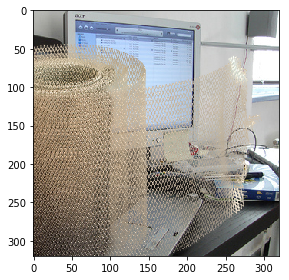

In [35]:
io.imshow((img.numpy().transpose(1,2,0)*255).astype(np.uint8))

# TRIMAP

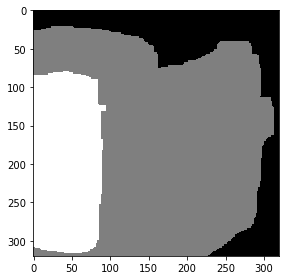

In [37]:
io.imshow((tri.numpy()*255).astype(np.uint8))

# GROUND TRUTH ALPHA MATTE

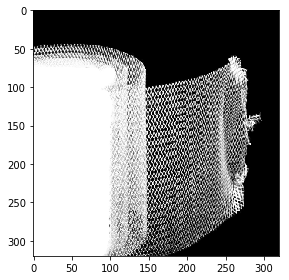

In [38]:
io.imshow((m.numpy()[0]*255).astype(np.uint8))

# PREDICTED ALPHA MATTE

In [39]:
pm = model_ft(imap.unsqueeze(0).to(device))

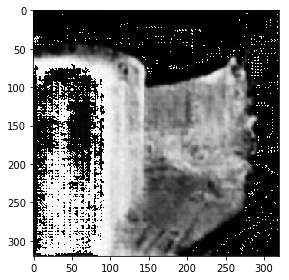

In [40]:
io.imshow((pm[0][0].cpu().detach().numpy()*255).astype(np.uint8))

# Debugging and Testing